In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [1]:
# Constants
g = 9.81  # Gravity (m/s^2)

# Metronome Parameters
m_pendulum = 0.05  # Mass of pendulum (kg)
L1_pendulum = 0.3  # Length of first pendulum (m)
L2_pendulum = 0.3  # Length of second pendulum (m)
epsilon = 0.15  # Escapement force coefficient
theta1_0_init=theta1_0 = 0.9  # Escapement threshold angle for metronome 1 (radians)
theta2_0_init=theta2_0 = 0.25  # Escapement threshold angle for metronome 2 (radians)
I1 = m_pendulum * L1_pendulum**2  # Inertia of first pendulum
I2 = m_pendulum * L2_pendulum**2
# Initial Conditions (Angles in radians)
omega1_0 = 0.0  # Initial angular velocity
omega2_0 = 0.0  # Initial angular velocity
x_0 = 0.0  # Initial displacement of the surface
v_0 = 0.0  # Initial velocity of the surface

# Time parameters
T_max = 30  # Simulation duration (s)
dt = 0.01  # Time step

# Cart Parameters
M_cart = 1.2  # Mass of the cart (kg)
B_cart = 0.1  # Damping coefficient
K_cart = 0.5  # Stiffness of the cart
#tau_input = 0# input torque


In [2]:
control_mode =  ["PD","PD","PD"] 

PD control paramter

In [3]:
# Control Parameters
Kp_PD = 4 # Proportional gain for PD control
Kd_PD = 0.2# Derivative gain for PD control

A_PD = -0.25  # Amplitude of reference sine signal for PD control
omega_PD = 0.5 + np.pi# Frequency of reference signal

NameError: name 'np' is not defined

Feedback Linerzation paramters

In [ ]:

kd1 = kd2 = kd3 = 0.01
kp1 = kp2 = kp3 = 0.8

Kp_FB = np.diag([kp1, kp2, kp3])  # Proportional gain for feedback linearization
Kd_FB = np.diag([kd1, kd2, kd3])  # Derivative gain for feedback linearization

In [ ]:

def metronome_matrix_system(t, y,Kd_PD ,Kp_PD ,control_mode):
    theta1, omega1, theta2, omega2, x, v = y  # Unpack state variables

    # Mass Matrix M(q)
    M_q = np.array([
        [I1, 0, m_pendulum * L1_pendulum * np.cos(theta1)],
        [0, I2, m_pendulum * L2_pendulum * np.cos(theta2)],
        [m_pendulum * L1_pendulum * np.cos(theta1), m_pendulum * L2_pendulum * np.cos(theta2), M_cart + 2 * m_pendulum]
    ])

    # Coriolis and Damping Matrix C(q, q_dot)
    C_q_qdot = np.array([
        [epsilon * ((theta1 / theta1_0)**2 - 1) * m_pendulum*(L1_pendulum**2), 0, 0],
        [0, epsilon * ((theta2 / theta2_0)**2 - 1) *m_pendulum*(L2_pendulum**2) , 0],
        [m_pendulum * L1_pendulum * np.sin(theta1) * omega1, m_pendulum * L2_pendulum * np.sin(theta2) * omega2, 0]
    ])

    # Gravity Matrix G(q)
    G_q = np.array([
        [m_pendulum * g * L1_pendulum * np.sin(theta1)],
        [m_pendulum * g * L2_pendulum * np.sin(theta2)],
        [0]  # No gravitational force directly on the cart
    ])



    # Control Input τ
    if control_mode[0] == "PD":
        # PD control to track a sinusoidal trajectory
        q_d = A_PD * np.sin(omega_PD * t)  # Reference trajectory
        q_tilde = q_d - x  # Tracking error
        tau_input = Kp_PD * q_tilde - Kd_PD * v  # PD control law

    elif control_mode == "FLC":
        # Feedback Linearization: Track Metronome 1's motion
        q_d = [theta1 ,theta1,-theta1] # Desired trajectory (Metronome 1)
        qq =[omega1,omega1,-omega1]
        q_tilde = q_d - np.array([[theta1], [theta2], [x]])  # Error between cart and metronome
        q_titlde_dot = qq - np.array([[omega1], [omega2], [v]]) 
        v_control = Kp_FB @  q_tilde+ Kd_FB @ q_titlde_dot
        tau_input = (M_q @ v_control + C_q_qdot @ np.array([[omega1], [omega2], [v]]) + G_q)[2, 0]  # Compute τ

    #CONTROL LOW
        # Compute intermediate terms
        K1 = m_pendulum * L1_pendulum * np.cos(theta1) * (kp1*q_tilde[0]+kd1*q_titlde_dot[0])
        K2 = m_pendulum * L2_pendulum * np.cos(theta2) * (kp2*q_tilde[1]+kd2*q_titlde_dot[1])
        K3 = (M_cart + 2 * m_pendulum)  * (kp3*q_tilde[1]+kd3*q_titlde_dot[2])
        
        # Compute control input τ
        tau = K1 + K2 + K3 - (m_pendulum * L1_pendulum * np.sin(theta1) * omega1**2) - (m_pendulum * L2_pendulum * np.sin(theta2) * omega2**2)
        
    elif control_mode=="NC":
        tau_input = 0  # No control applied
        # Input Torque Matrix τ (assumed zero external force)
    
    Tau = np.array([[0],[0],[tau_input] ]) # External force on the cart 

    # Solve for accelerations: M(q) * q_ddot + C(q, q_dot) * q_dot + G(q)=Tau
    q_ddot = np.linalg.solve(M_q, (Tau - np.dot(C_q_qdot, np.array([[omega1], [omega2], [v]])) - G_q))
    
    return [omega1, q_ddot[0, 0], omega2, q_ddot[1, 0], v, q_ddot[2, 0]]







In [ ]:
class solver():
    """
    solver object for the feedback linearisation control

    stores the feedback derivative gain, proportional gain and all results in the model
    """
    def __init__(self, kd, kp,control_mode ,T_max=50):
        """
        set up the solver with an input kd, kp and t_max
        """
        self.kd = kd
        self.kp = kp
        self.T_max = T_max
        self.control_mode = control_mode

        # set up the attributes for the model object to fill
        self.time = []
        self.theta1 = []
        self.qdd1 = []
        self.theta2 = []
        self.qdd2 = []
        self.surface_x = []
        self.qdd3 = []

        self.sync_time = -1
        self.sync_threshold = -1
        self.energy_plot = []
        self.system_energy = -1

    def solve(self, dt=0.01):
        """
        solve the ode with scipy.integrate.solve_ivp(), retrieve the results and fill the model objects attributes

        Args:
            dt (float, optional): change in time for integrator. Defaults to 0.01.

        Returns:
            solver object: model object     # probably unnecessary tbh
        """
        t_span = (0, self.T_max)
        y0 = [theta1_0_init, omega1_0, theta2_0_init, omega2_0, x_0, v_0]
        t_eval = np.arange(0, self.T_max, dt)

        sol = solve_ivp(metronome_matrix_system, t_span, y0, args=[self.kd, self.kp, control_mode], t_eval=t_eval, method="RK45")

        # Extract solutions
        self.time = sol.t                # time
        self.theta1 = sol.y[0]           # angle of metronome 1
        self.qdd1 = sol.y[1]             # acceleration of metronome 1
        self.theta2 = sol.y[2]           # angle of metronome 1
        self.qdd2 = sol.y[3]             # acceleration of metronome 2
        self.surface_x = sol.y[4]        # Surface displacement
        self.qdd3 = sol.y[5]             # acceleration of cart

        return self

    def find_sync_time(self, sync_threshold=1.0):
        """
        find the sync time for the metronomes to a set accuracy or lower - if accuracy cannot be 
        reached, reduce by 0.05 until an accuracy is reached. records both time and accuracy.

        sync is determined if the average value of the phase diff of the two metronomes for the prior 3 seconds
        are within the threshold synchronicity set. returns the value of 3 seconds ago where the sync began

        Args:
            sync_threshold (float, optional): sync threshold (0 - 1). Defaults to 1.0.

        Returns:
            floats: threshold, time to sync     
            # redundant since the model attributes are filled anyway, left for compatability with old code
        """
        sync = False
        while not sync:
            for t in range(300, len(self.time)):
                phase_diff = np.abs(self.theta1[t-300:t] - self.theta2[t-300:t])
                avg_sync = np.mean(1 - phase_diff)

                # adjust this to increase threshold for synchronicity
                if avg_sync >= sync_threshold:
                    #print(f"Synched at {self.time[t-300]} with synch {avg_sync}")
                    sync = True
                    self.sync_time = self.time[t-300]
                    self.sync_threshold = sync_threshold
                    return sync_threshold, self.time[t-300]
                
            sync_threshold -= 0.05

    def calc_energy(self,M_cart,m_pendulum ):
        """
        calculate the energy of a flc system of two metronomes with given input kd and kp

        calculates the energy as a combination of kinetic of both metronomes and cart + gpe from
        both metronomes using standard formula / predefined formula

        Returns:
            _type_: model, sync time, total energy (array)
        """

        # calc kinetic energy of metronomes
        # ke = 1/2 * I * omega**2
        # I = m * L**2
        # so ke = 1/2 * m * L**2 * omega**2
        ke_1 = 1/2 * m_pendulum * L1_pendulum**2 * self.qdd1**2
        ke_2 = 1/2 * m_pendulum * L2_pendulum**2 * self.qdd2**2

        # calc kinetic energy of cart
        # ke = 1/2 * m * v**2
        ke_3 = 1/2 * M_cart * self.qdd3**2

        total_ke = ke_1 + ke_2 + ke_3

        # calc gpe of metronomes
        # gpe = m * g * h
        # h = L * cos (theta)abs(
        gpe_1 = m_pendulum * g * L1_pendulum * np.cos(self.theta1)
        gpe_2 = m_pendulum * g * L2_pendulum * np.cos(self.theta2)

        total_gpe = gpe_1 + gpe_2

        # total energy
        total_energy = total_ke + total_gpe

        self.energy_plot = total_energy
        self.system_energy = np.sum(np.abs(total_energy))

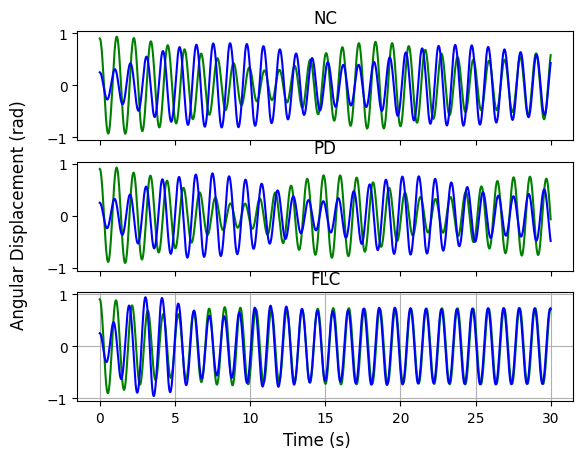

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True)
#plt.xlim(1,6)
fig.supxlabel("Time (s)")
fig.supylabel("Angular Displacement (rad)")
#plt.title("Metronome Oscillations")
#plt.legend()
plt.grid()
for control,ax in zip(control_mode, (ax1, ax2, ax3)):
    time, theta1, theta2 = solver(control)
    ax.set_title(control)
    ax.plot(time, theta1, label="Metronome 1", color='g')
    ax.plot(time, theta2, label="Metronome 2", color='b')


plt.show()